# MNIST (PCA40 + KNN)

In [1]:
#Libraries
from __future__ import print_function
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata
from sklearn.grid_search import GridSearchCV
from sklearn import svm, metrics, cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import timeit

In [2]:
#Load MNIST Data
mnist = fetch_mldata("MNIST original")

# rescale the data
X, y = mnist.data / 255., mnist.target

# separate train, test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [3]:
np.shape(X)

(70000, 784)

In [4]:
np.shape(y)

(70000,)

In [5]:
np.shape(X_train)

(60000, 784)

In [6]:
np.shape(y_train)

(60000,)

In [7]:
np.shape(X_test)

(10000, 784)

In [8]:
np.shape(y_test)

(10000,)

# PCA: Components: 40

In [9]:
# select number of components to extract
pca = PCA(n_components=40)
pca.fit(X_train)



PCA(copy=True, n_components=40, whiten=False)

# Feature extraction

In [10]:
train_ext = pca.transform(X_train)
test_ext = pca.transform(X_test)

In [11]:
np.shape(train_ext)

(60000, 40)

In [12]:
np.shape(test_ext)

(10000, 40)

# Ploting

Variance explained with 40 components: 0.7861


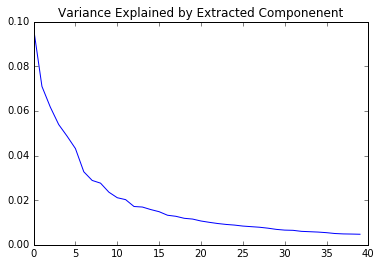

In [13]:
print("Variance explained with 40 components: %.4f" % np.sum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance Explained by Extracted Componenent')
plt.show()

# KNN: n_neighbors: 5

In [14]:
knn = KNeighborsClassifier()
start_time = timeit.default_timer()
knn.fit(train_ext, y_train)
elapsed = timeit.default_timer() - start_time
print("KNN fit time: %.2f sec" % (elapsed))

KNN fit time: 0.15 sec


Make predictions on test data

In [15]:
start_time = timeit.default_timer()
predicted = knn.predict(test_ext)
elapsedPredict = timeit.default_timer() - start_time
print("KNN predict time: %.2f sec" % (elapsedPredict))

KNN predict time: 26.22 sec


# Cross Validation: Folds: 5

In [16]:
start_time = timeit.default_timer()
scores = cross_validation.cross_val_score(knn, train_ext, y_train, cv=5, n_jobs=-1)
elapsedCV = timeit.default_timer() - start_time
print("Cross validatione time: %.2f sec" % (elapsedCV))
np.set_printoptions(precision=4)
print("Cross validation scores:", scores)
print("Cross validation mean: %0.3f (+/-%0.03f)" % (scores.mean(), scores.std() * 2))

Cross validatione time: 41.99 sec
Cross validation scores: [ 0.9756  0.9749  0.9738  0.9735  0.9743]
Cross validation mean: 0.974 (+/-0.002)


# Classification metrics

In [17]:
print("\nAccuracy on test data: %.4f" % metrics.accuracy_score(y_test, predicted))


Accuracy on test data: 0.9745


# Confusion matrix:

In [18]:
print(metrics.confusion_matrix(y_test, predicted, range(10)))

[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1129    3    1    0    0    1    0    0    1]
 [   7    1 1005    0    1    0    3   10    5    0]
 [   0    0    3  977    1   10    0    7   10    2]
 [   2    1    0    0  956    0    5    1    0   17]
 [   3    1    0    8    1  869    4    1    1    4]
 [   3    4    0    0    2    1  948    0    0    0]
 [   0   17    8    1    3    0    0  990    0    9]
 [   5    0    4   14    2   10    4    3  927    5]
 [   4    4    3    7    7    3    1    6    3  971]]


# Classification report:

    *precision: truePositives / (truePositives + falsePositives)
    *recall: truePositives / Positives
    *f1-score: 2 (precision recall) / (precision + recall)
    *support: Cantidad de ocurrencias



In [19]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98       980
        1.0       0.97      0.99      0.98      1135
        2.0       0.98      0.97      0.98      1032
        3.0       0.97      0.97      0.97      1010
        4.0       0.98      0.97      0.98       982
        5.0       0.97      0.97      0.97       892
        6.0       0.98      0.99      0.98       958
        7.0       0.97      0.96      0.97      1028
        8.0       0.98      0.95      0.97       974
        9.0       0.96      0.96      0.96      1009

avg / total       0.97      0.97      0.97     10000



# Error samples:

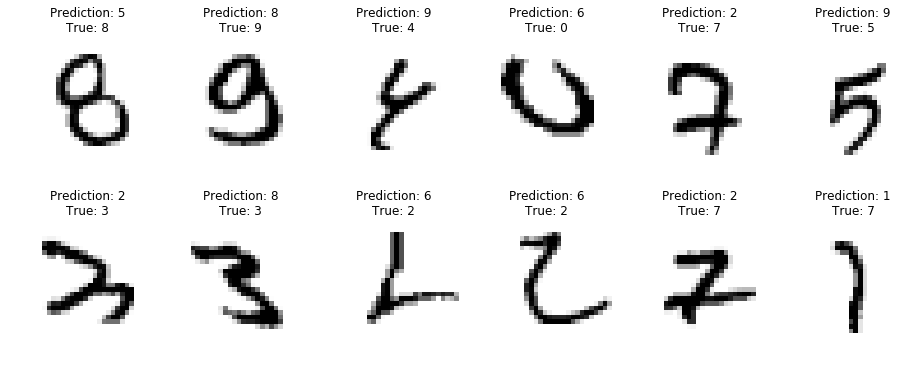

In [20]:
misslabels = predicted[y_test != predicted]
reallabels = y_test[y_test != predicted]
missimages = X_test[y_test != predicted]
choice = np.random.choice(range(len(misslabels)), 12, replace=False)
plt.figure(figsize=(16, 6))
for index, i in enumerate(choice):
    plt.subplot(2, 6, index+1)
    plt.axis('off')
    plt.imshow(missimages[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i\nTrue: %i' % (misslabels[i], reallabels[i]))

In [21]:
df = pd.DataFrame(metrics.confusion_matrix(y_test, predicted, range(10)))
df.to_csv('knnWithPreprocessPCA40.csv')
with open('knnWithPreprocessPCA40.txt', 'w') as file_:
    file_.write('%.4f' % elapsed)